In [1]:
!pip install nltk kagglehub matplotlib pandas


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!pip install nltk


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms
from PIL import Image
import os
import collections
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import random
import pandas as pd # For DataFrame and CSV operations
import datetime

In [5]:
!pip install kagglehub

  Using cached kagglehub-0.3.12-py3-none-any.whl.metadata (38 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 2.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:29<00:00, 37.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [2]:
!mkdir -p /workspace/flickr8k
!mv $path /workspace/flickr8k
path= "/workspace/flickr8k/1"

# Step 4: Set paths

# Path to the dataset directory
# Path to the dataset directory
dataset_path = path
image_folder = os.path.join(dataset_path, "Images")
caption_file = os.path.join(dataset_path, "captions.txt")

print(image_folder)

mv: missing destination file operand after '/workspace/flickr8k'
Try 'mv --help' for more information.
/workspace/flickr8k/1/Images


In [3]:
print(image_folder)
print(caption_file)

/workspace/flickr8k/1/Images
/workspace/flickr8k/1/captions.txt


In [4]:
!mkdir -p /workspace/models

In [5]:
# --- 0. Configuration and Hyperparameters ---
# This dictionary stores all key settings for the model and training process.
CONFIG = {
    "image_dir": "/workspace/flickr8k/1/Images",
    "captions_path": "/workspace/flickr8k/1/captions.txt",
    "vocab_threshold": 1,           # Minimum word count to be included in the vocabulary.
                                    # Words appearing less frequently will be treated as <UNK>.
    "max_seq_length": 20,           # Maximum length of a caption sequence (including <SOS>, <EOS>, <PAD>).
                                    # Captions longer than this will be truncated, shorter will be padded.
    "batch_size": 32,               # Number of samples (image, caption pairs) processed in one forward/backward pass.
    "embed_size": 512,              # Dimensionality of the word embeddings and the output of the CNN encoder.

    "hidden_size": 512,             # Dimensionality of the hidden state in the LSTM layers.
                                    # Represents the "memory" capacity of the LSTM.
    "num_layers": 1,                # Number of recurrent layers in the LSTM.
    "learning_rate": 0.001,         # Learning rate for the Adam optimizer.
    "num_epochs": 25,                # Number of times to iterate over the entire training dataset.

    "log_step": 100,                 # Print training progress every N batches.
    "save_step": 1,                 # Save model checkpoints every N epochs.
    "model_path": "/workspace/models/",        # Directory to save trained model weights.
    "vocab_path": "vocab.pkl", # Path to save/load the vocabulary object (not used in this example but common).
    # Paths for test phase outputs
    "test_predictions_file": "/workspace/TestPredictions_CLIP_LSTM.csv",
    "test_scores_file": "/workspace/TestScores_CLIP_LSTM.csv"
}


In [6]:
# Smoothing function for BLEU to handle zero counts
smooth_fn = SmoothingFunction().method1

In [7]:
# --- 1. Vocabulary Class ---
# Manages the mapping between words and their integer indices,
# including handling special tokens and infrequent words.
class Vocabulary(object):
    def __init__(self, vocab_threshold, vocab_file='vocab.pkl'):
        """Initializes the Vocabulary object.
        Args:
            vocab_threshold (int): Minimum word count to include in the vocabulary.
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file # Not directly used for saving in this snippet, but good practice
        self.word2idx = {}           # Dictionary mapping words to integer indices.
        self.idx2word = {}           # Dictionary mapping integer indices back to words.
        self.idx = 0                 # Counter for assigning new indices.
        self.create_vocab = False    # Flag to indicate if vocabulary has been built.

        # Add special tokens first to ensure they have fixed, low indices.
        self.add_word('<PAD>')  # Padding token (index 0) - used to make sequences uniform length.
        self.add_word('<SOS>')  # Start Of Sentence token - marks the beginning of a caption.
        self.add_word('<EOS>')  # End Of Sentence token - marks the end of a caption.
        self.add_word('<UNK>')  # Unknown token - represents words not in the vocabulary.

    def add_word(self, word):
        """Adds a word to the vocabulary if it's not already present."""
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, captions):
        """Builds the vocabulary from a list of tokenized captions.
        Counts word frequencies and includes words above the threshold.
        Args:
            captions (list of lists of str): List of tokenized captions (e.g., [['word1', 'word2'], ...]).
        """
        counter = collections.Counter()
        for caption_tokens in captions:
            counter.update(caption_tokens) # Count occurrences of each word.

        # Filter words based on the vocabulary threshold.
        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        # Add the remaining frequent words to the vocabulary.
        for i, word in enumerate(words):
            self.add_word(word)
        
        self.create_vocab = True # Mark vocabulary as built.

    def __call__(self, word):
        """Returns the index for a given word, or <UNK> if not found."""
        if word not in self.word2idx:
            return self.word2idx['<UNK>']
        return self.word2idx[word]

    def __len__(self):
        """Returns the total number of words in the vocabulary."""
        return len(self.word2idx)


In [8]:
# --- 2. Dataset Class ---
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions_path, vocab, transform=None, max_seq_length=20):
        self.image_dir = image_dir
        self.captions = self._load_captions(captions_path)
        self.image_names = list(self.captions.keys()) # Store unique image names
        self.vocab = vocab
        self.transform = transform
        self.max_seq_length = max_seq_length

        self.data_pairs = []
        for img_name, caption_list in self.captions.items():
            for caption_text in caption_list:
                self.data_pairs.append((img_name, caption_text))

    def _load_captions(self, captions_path):
        """
        Loads captions from a .txt file with "image_name.jpg,caption words" format.
        Args:
            captions_path (str): Path to the captions text file.
        Returns:
            dict: A dictionary where keys are image filenames and values are lists of captions for that image.
        """
        captions_data = collections.defaultdict(list) # Use defaultdict to easily append captions to image keys.

        try:
            with open(captions_path, 'r', encoding='utf-8') as f:
                # --- ADDED LINE TO SKIP HEADER ---
                next(f) # Skip the first line (header)
                # --- END ADDED LINE ---
                # Iterate through each line in the captions file.
                for line in f:
                    line = line.strip() # Remove leading/trailing whitespace.
                    if not line: # Skip empty lines.
                        continue

                    # Split the line by the first comma to separate image filename from caption.
                    parts = line.split(',', 1)
                    if len(parts) != 2: # Check for malformed lines.
                        print(f"Skipping malformed line: {line} (Expected 'image,caption' format)")
                        continue

                    image_filename, caption = parts[0], parts[1]
                    # Add caption to the list for the corresponding image.
                    captions_data[image_filename.strip()].append(caption.strip())
            print(f"Loaded {sum(len(v) for v in captions_data.values())} captions for {len(captions_data)} images from {captions_path}")
            return dict(captions_data) # Convert defaultdict back to a regular dict.

        except FileNotFoundError:
            print(f"Caption file '{captions_path}' not found. Please ensure it's in the correct directory.")
            print("Creating dummy images and a dummy .txt caption file for demonstration.")
            # If file not found, create dummy data for demonstration purposes.
            return self._create_dummy_captions()

    def _create_dummy_captions(self, num_dummy_images=100):
        dummy_captions = collections.defaultdict(list)
        os.makedirs(CONFIG["image_dir"], exist_ok=True)

        lines_to_write = []
        lines_to_write.append("image_name#id\tcaption_text") # Matching Flickr8k.token.txt style

        for i in range(num_dummy_images):
            img_name = f"image_{i}.jpg"
            Image.new('RGB', (224, 224), color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))).save(os.path.join(CONFIG["image_dir"], img_name))

            caption1 = f"a dummy caption for image {i}."
            caption2 = f"this is another example caption for image {i}, with a comma."
            caption3 = f"image {i} shows a test scene."
            caption4 = f"a random colored box labeled as {i}."
            caption5 = f"simple abstract art with number {i}."


            dummy_captions[img_name].extend([caption1, caption2, caption3, caption4, caption5])

            lines_to_write.append(f"{img_name}#0\t{caption1}")
            lines_to_write.append(f"{img_name}#1\t{caption2}")
            lines_to_write.append(f"{img_name}#2\t{caption3}")
            lines_to_write.append(f"{img_name}#3\t{caption4}")
            lines_to_write.append(f"{img_name}#4\t{caption5}")

        with open(CONFIG["captions_path"], 'w', encoding='utf-8') as f:
            for line in lines_to_write:
                f.write(line + '\n')

        print(f"Created {num_dummy_images} dummy images in {CONFIG['image_dir']}")
        print(f"Dummy .txt captions created at {CONFIG['captions_path']}")
        return dict(dummy_captions)

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        img_name, caption_text = self.data_pairs[idx]
        image_path = os.path.join(self.image_dir, img_name)
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        tokens = nltk.word_tokenize(caption_text.lower())

        caption_tokens = ['<SOS>'] + tokens + ['<EOS>']

        caption_indices = [self.vocab(token) for token in caption_tokens]

        padded_caption = torch.full((self.max_seq_length,), self.vocab('<PAD>'), dtype=torch.long)

        actual_len = min(len(caption_indices), self.max_seq_length)
        padded_caption[:actual_len] = torch.tensor(caption_indices[:actual_len], dtype=torch.long)

        return image, padded_caption, img_name, caption_text



In [9]:
# --- 3. Encoder (ResNet CNN) ---
# This module acts as the image feature extractor.
# It uses a pre-trained ResNet model and modifies its final layer
# to produce an output compatible with the LSTM decoder.
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Initializes the EncoderCNN.
        Args:
            embed_size (int): The dimensionality of the output image features.
        """
        super(EncoderCNN, self).__init__()
        # Load a pre-trained ResNet50 model (trained on ImageNet).
        # `weights=models.ResNet50_Weights.IMAGENET1K_V1` ensures we get the pre-trained weights.
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Remove the last fully connected (classification) layer of ResNet.
        # We only want the feature extractor part. `resnet.children()` gives modules, `[:-1]` excludes the last one.
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        
        # Add a new fully connected layer to map ResNet's output features (e.g., 2048 for ResNet50)
        # to the desired `embed_size`. This makes the image features compatible with the LSTM input.
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        # Add Batch Normalization for stability, especially after a linear transformation.
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        """
        Forward pass for the encoder.
        Args:
            images (torch.Tensor): Input image tensor (batch_size, channels, height, width).
        Returns:
            torch.Tensor: Extracted image features (batch_size, embed_size).
        """
        # Disable gradient calculation for the pre-trained ResNet layers.
        # This means their weights won't be updated during training, leveraging transfer learning.
        # Only the `linear` and `bn` layers will be trained initially.
        with torch.no_grad():
            features = self.resnet(images)
        
        # Flatten the features. ResNet's output after `[:-1]` is typically (batch_size, channels, 1, 1).
        # `.view(features.size(0), -1)` flattens to (batch_size, channels).
        features = features.view(features.size(0), -1)
        
        # Apply the linear transformation and batch normalization.
        features = self.bn(self.linear(features))
        return features


In [10]:
import torch
import torch.nn as nn

class DecoderRNN(nn.Module):
    # ... (Your existing __init__ and forward methods remain the same) ...
    # Ensure your __init__ has the dropout_prob as discussed previously
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout_prob=0.7):
        super(DecoderRNN, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.vocab = None # Placeholder. Ensure you set this in your main script or pass it correctly.

    def forward(self, features, captions):
        # ... (Your existing forward method as discussed with dropout and loss alignment) ...
        embeddings = self.word_embeddings(captions)
        features_unsqueeze = features.unsqueeze(1)
        inputs = torch.cat((features_unsqueeze, embeddings), 1)
        hiddens, _ = self.lstm(inputs)
        hiddens = self.dropout(hiddens) # Apply dropout after LSTM output during training
        outputs = self.fc(hiddens)
        return outputs

    def sample(self, features, states=None, max_seq_length=75):
        """
        Generate captions for image features using greedy search for a batch of images.

        Args:
            features (torch.Tensor): Output features from the encoder (batch_size, embed_size).
            states (tuple, optional): Initial hidden and cell states for the LSTM. Defaults to None.
            max_seq_length (int): Maximum length of the generated caption.

        Returns:
            torch.Tensor: A tensor of predicted word indices for the batch,
                          shape (batch_size, generated_sequence_length).
        """
        # Set the model to evaluation mode; dropout layers are automatically disabled.
        # This should ideally be done *outside* this method, before calling it, e.g., decoder.eval().
        # However, it's harmless to ensure it here for robustness if not done globally.
        self.eval() 

        # Initialize a list to collect predicted token IDs for each time step across the batch
        all_predicted_tokens_batch = []
        
        # Tensor to keep track of which sequences in the batch have finished (predicted <EOS>)
        # Initially, no sequence has finished.
        finished_sequences = torch.zeros(features.size(0), dtype=torch.bool, device=features.device)
        
        # The initial input to the LSTM is the image features
        inputs = features.unsqueeze(1) # Reshape to (batch_size, 1, embed_size) for LSTM input

        for _ in range(max_seq_length): # Loop for generating sequence tokens
            hiddens, states = self.lstm(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            
            # Squeeze the sequence dimension from hiddens before passing to FC layer
            # This makes outputs: (batch_size, vocab_size)
            outputs = self.fc(hiddens.squeeze(1))        
            
            # Get the predicted word for each item in the batch
            _, predicted_batch = outputs.max(1)          # predicted_batch: (batch_size)

            # Append the tensor of predicted tokens for this time step
            all_predicted_tokens_batch.append(predicted_batch)

            # Update finished_sequences for sequences that have predicted the <EOS> token
            # This ensures we stop extending sequences that are complete.
            # We use torch.logical_or to update finished_sequences cumulatively.
            # Using == directly on the tensor correctly performs element-wise comparison.
            is_eos_predicted = (predicted_batch == self.vocab('<EOS>'))
            finished_sequences = torch.logical_or(finished_sequences, is_eos_predicted)

            # If all sequences in the batch have finished, we can break early
            if finished_sequences.all():
                break
            
            # Prepare input for the next step: embeddings of the predicted words
            # Use unsqueeze(1) to add the sequence dimension (1) back
            inputs = self.word_embeddings(predicted_batch).unsqueeze(1) 
        
        # Stack the list of predicted token tensors into a single tensor
        # The result will be (seq_len, batch_size) if dim=0, so stack on dim=1 and it becomes (batch_size, seq_len)
        generated_ids_tensor = torch.stack(all_predicted_tokens_batch, dim=1) 

        return generated_ids_tensor

In [11]:
# --- 5. Test Inference Function ---
def test_inference(encoder, decoder, test_loader, vocab, device):
    encoder.eval()
    decoder.eval()
    all_img_names = []
    all_predictions = []

    print("\nStarting Test Inference...")
    with torch.no_grad():
        for i, (images, _, img_names, _) in enumerate(test_loader):
            images = images.to(device)
            features = encoder(images)
            sampled_ids_batch = decoder.sample(features)

            for k in range(sampled_ids_batch.size(0)):
                generated_tokens = []
                for word_id in sampled_ids_batch[k].cpu().numpy():
                    word = vocab.idx2word[word_id]
                    if word == '<EOS>':
                        break
                    if word == '<SOS>' or word == '<PAD>':
                        continue
                    generated_tokens.append(word)

                all_img_names.append(img_names[k])
                all_predictions.append(' '.join(generated_tokens))

            if (i + 1) % 10 == 0:
                print(f"Processed {len(all_predictions)} test samples...")
    print("Test inference complete.")
    return all_img_names, all_predictions


In [12]:
# --- 6. Metrics Calculation Class ---
class MetricsCalculator:
    def __init__(self, ground_truth_captions_map, predicted_captions_filepath, scores_output_filepath):
        self.ground_truth_captions_map = ground_truth_captions_map # Dict: {img_name: [tokenized_ref1, ...]}
        self.predicted_captions_filepath = predicted_captions_filepath
        self.scores_output_filepath = scores_output_filepath
        self.smooth_fn = SmoothingFunction().method1

    def calculate_and_save(self):
        try:
            predicted_df = pd.read_csv(self.predicted_captions_filepath)
        except FileNotFoundError:
            print(f"Error: Predicted captions file not found at {self.predicted_captions_filepath}")
            return

        all_bleu_scores_data = []

        print(f"Calculating BLEU scores for {len(predicted_df)} predictions...")
        for index, row in predicted_df.iterrows():
            img_name = row['ImageName']
            predicted_caption_str = row['Predicted']

            # Tokenize the predicted caption string
            tokenized_predicted_caption = nltk.word_tokenize(predicted_caption_str.lower())

            # Retrieve ground truth references (must already be tokenized lists of strings)
            references_for_image = self.ground_truth_captions_map.get(img_name, [])

            bleu1, bleu2, bleu3, bleu4 = 0.0, 0.0, 0.0, 0.0
            if references_for_image:
                bleu1 = sentence_bleu(references_for_image, tokenized_predicted_caption, weights=(1.0,), smoothing_function=self.smooth_fn)
                bleu2 = sentence_bleu(references_for_image, tokenized_predicted_caption, weights=(0.5, 0.5), smoothing_function=self.smooth_fn)
                bleu3 = sentence_bleu(references_for_image, tokenized_predicted_caption, weights=(1./3., 1./3., 1./3.), smoothing_function=self.smooth_fn)
                bleu4 = sentence_bleu(references_for_image, tokenized_predicted_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=self.smooth_fn)

            all_bleu_scores_data.append({
                'ImageName': img_name,
                'PredictedCaption': predicted_caption_str,
                'BLEU-1': bleu1,
                'BLEU-2': bleu2,
                'BLEU-3': bleu3,
                'BLEU-4': bleu4
            })

        scores_df = pd.DataFrame(all_bleu_scores_data)

        os.makedirs(os.path.dirname(self.scores_output_filepath), exist_ok=True)
        scores_df.to_csv(self.scores_output_filepath, index=False)
        print(f"Individual BLEU scores saved to {self.scores_output_filepath}")


In [13]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [14]:
# --- Main Execution Block ---
# This block runs when the script is executed.
if __name__ == "__main__":
    # --- Image Transformations ---
    # Define a sequence of transformations to apply to input images.
    transform = transforms.Compose([
        transforms.Resize((224, 224)), # Resize images to 224x224 pixels, a common size for ResNet.
        transforms.ToTensor(),         # Convert PIL Image to PyTorch Tensor (scales pixel values to [0, 1]).
        # Normalize pixel values using ImageNet's mean and standard deviation.
        # This aligns image distribution with what pre-trained ResNet expects.
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


In [15]:
# Load full dataset to build vocabulary
full_dataset_for_vocab = Flickr8kDataset(CONFIG["image_dir"], CONFIG["captions_path"], None)

Loaded 40455 captions for 8091 images from /workspace/flickr8k/1/captions.txt


In [16]:
all_caption_texts_for_vocab = []
# Build a map of all image names to all their tokenized captions for later use
# This map will be used for both validation and test sets
all_image_to_captions_map = collections.defaultdict(list)

for img_name, caption_list in full_dataset_for_vocab.captions.items():
    for caption_text in caption_list:
        tokenized_caption = nltk.word_tokenize(caption_text.lower())
        all_caption_texts_for_vocab.append(tokenized_caption)
        all_image_to_captions_map[img_name].append(tokenized_caption)

vocab = Vocabulary(CONFIG["vocab_threshold"])
vocab.build_vocabulary(all_caption_texts_for_vocab)
print(f"Vocabulary size: {len(vocab)}")


Vocabulary size: 8922


In [17]:
 # Create the full dataset with the built vocabulary
full_dataset = Flickr8kDataset(CONFIG["image_dir"], CONFIG["captions_path"], vocab, transform, CONFIG["max_seq_length"])


Loaded 40455 captions for 8091 images from /workspace/flickr8k/1/captions.txt


In [18]:
# Split dataset into training, validation, and test sets
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=4)

In [19]:
 # --- Model Initialization ---
encoder = EncoderCNN(CONFIG["embed_size"])
decoder = DecoderRNN(CONFIG["embed_size"], CONFIG["hidden_size"], len(vocab), CONFIG["num_layers"])
decoder.vocab = vocab # Set vocab for sampling in decoder

  

In [20]:
# --- Device Setup (CPU/GPU) ---
    # Move models to GPU if CUDA is available, otherwise use CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (word_embeddings): Embedding(8922, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=8922, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
)

In [21]:
# --- Loss Function and Optimizer ---
    # CrossEntropyLoss is suitable for multi-class classification (predicting the next word from vocab).
    # `ignore_index=vocab('<PAD>')` ensures that padding tokens do not contribute to the loss.
criterion = nn.CrossEntropyLoss(ignore_index=vocab('<PAD>'))

In [22]:
# Optimizer: Adam is a popular choice for deep learning.
    # We collect parameters from both decoder and the *trainable parts* of the encoder (linear and bn layers).
    # The pre-trained ResNet layers (self.resnet) are frozen by `with torch.no_grad()` in EncoderCNN.
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = optim.Adam(params, lr=CONFIG["learning_rate"])

In [23]:
 # --- Lists to store metrics for plotting ---
epochs_list = []
train_losses = []
val_losses = []
bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []

In [24]:
print("\nStarting Training...")
total_step = len(train_loader)
for epoch in range(CONFIG["num_epochs"]):
    start_time_epoch = datetime.datetime.now()
    print(f"\n--- Epoch {epoch+1}/{CONFIG['num_epochs']} started at: {start_time_epoch.strftime('%Y-%m-%d %H:%M:%S')} ---")
    encoder.train() # Set encoder to training mode.
    decoder.train() # Set decoder to training mode.
    running_loss = 0.0 # Accumulator for training loss.
    
    for i, (images, captions, _, _) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()

        features = encoder(images)
        outputs = decoder(features, captions)

        #loss = criterion(outputs[:, :-1].reshape(-1, len(vocab)), captions[:, 1:].reshape(-1))
        loss = criterion(outputs[:, :captions.size(1)].reshape(-1, len(vocab)), captions.reshape(-1))

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        if i % CONFIG["log_step"] == 0:
            print(f"Epoch [{epoch+1}/{CONFIG['num_epochs']}], Step [{i+1}/{total_step}], Train Loss: {loss.item():.4f}")

    avg_train_loss = running_loss / len(train_dataset)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{CONFIG['num_epochs']}], Avg Train Loss: {avg_train_loss:.4f}")

    # --- Validation after each epoch (including BLEU scores) ---
    encoder.eval()
    decoder.eval()
    val_loss_epoch = 0.0

    all_val_references = []
    all_val_candidates = []

    with torch.no_grad():
        for images, captions, img_names, _ in val_loader:
            images = images.to(device)
            captions = captions.to(device)

            features = encoder(images)
            outputs = decoder(features, captions)
            #val_loss_epoch += criterion(outputs[:, :-1].reshape(-1, len(vocab)), captions[:, 1:].reshape(-1)).item() * images.size(0)
            val_loss_epoch += criterion(outputs[:, :captions.size(1)].reshape(-1, len(vocab)), captions.reshape(-1)).item() * images.size(0)

            sampled_ids_batch = decoder.sample(features)

            for k in range(sampled_ids_batch.size(0)):
                generated_tokens = []
                for word_id in sampled_ids_batch[k].cpu().numpy():
                    word = vocab.idx2word[word_id]
                    if word == '<EOS>':
                        break
                    if word == '<SOS>' or word == '<PAD>':
                        continue
                    generated_tokens.append(word)

                current_image_name = img_names[k]
                # Get all references for this image from the pre-built map
                references_for_image = all_image_to_captions_map.get(current_image_name, [])

                if references_for_image:
                    all_val_references.append(references_for_image)
                    all_val_candidates.append(generated_tokens)

    avg_val_loss = val_loss_epoch / len(val_dataset)
    val_losses.append(avg_val_loss)

    current_bleu1_scores = []
    current_bleu2_scores = []
    current_bleu3_scores = []
    current_bleu4_scores = []

    if all_val_candidates:
        for candidate, references in zip(all_val_candidates, all_val_references):
            if references:
                current_bleu1_scores.append(sentence_bleu(references, candidate, weights=(1.0,), smoothing_function=smooth_fn))
                current_bleu2_scores.append(sentence_bleu(references, candidate, weights=(0.5, 0.5), smoothing_function=smooth_fn))
                current_bleu3_scores.append(sentence_bleu(references, candidate, weights=(1./3., 1./3., 1./3.), smoothing_function=smooth_fn))
                current_bleu4_scores.append(sentence_bleu(references, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn))
            else:
                current_bleu1_scores.append(0.0) # No references, score is 0
                current_bleu2_scores.append(0.0)
                current_bleu3_scores.append(0.0)
                current_bleu4_scores.append(0.0)

    avg_bleu1 = np.mean(current_bleu1_scores) if current_bleu1_scores else 0.0
    avg_bleu2 = np.mean(current_bleu2_scores) if current_bleu2_scores else 0.0
    avg_bleu3 = np.mean(current_bleu3_scores) if current_bleu3_scores else 0.0
    avg_bleu4 = np.mean(current_bleu4_scores) if current_bleu4_scores else 0.0

    bleu1_scores.append(avg_bleu1)
    bleu2_scores.append(avg_bleu2)
    bleu3_scores.append(avg_bleu3)
    bleu4_scores.append(avg_bleu4)
    epochs_list.append(epoch + 1)

    print(f"Epoch [{epoch+1}/{CONFIG['num_epochs']}], Val Loss: {avg_val_loss:.4f}, "
          f"BLEU-1: {avg_bleu1:.4f}, BLEU-2: {avg_bleu2:.4f}, BLEU-3: {avg_bleu3:.4f}, BLEU-4: {avg_bleu4:.4f}\n")

    if (epoch + 1) % CONFIG["save_step"] == 0:
        torch.save(decoder.state_dict(), os.path.join(CONFIG["model_path"], f"decoder-{epoch+1}.pth"))
        torch.save(encoder.state_dict(), os.path.join(CONFIG["model_path"], f"encoder-{epoch+1}.pth"))
        print(f"Models saved at epoch {epoch+1}")
# --- End of Epoch Time and Duration ---
    end_time_epoch = datetime.datetime.now()
    time_taken_epoch = end_time_epoch - start_time_epoch
    print(f"--- Epoch {epoch+1}/{CONFIG['num_epochs']} finished at: {end_time_epoch.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"--- Time taken for Epoch {epoch+1}: {time_taken_epoch} ---")
print("Training complete!")


Starting Training...

--- Epoch 1/25 started at: 2025-07-11 14:04:08 ---
Epoch [1/25], Step [1/1012], Train Loss: 9.1038
Epoch [1/25], Step [101/1012], Train Loss: 3.9341
Epoch [1/25], Step [201/1012], Train Loss: 3.5567
Epoch [1/25], Step [301/1012], Train Loss: 3.5614
Epoch [1/25], Step [401/1012], Train Loss: 3.5812
Epoch [1/25], Step [501/1012], Train Loss: 3.0632
Epoch [1/25], Step [601/1012], Train Loss: 3.1805
Epoch [1/25], Step [701/1012], Train Loss: 3.4041
Epoch [1/25], Step [801/1012], Train Loss: 3.3561
Epoch [1/25], Step [901/1012], Train Loss: 3.2348
Epoch [1/25], Step [1001/1012], Train Loss: 3.6199
Epoch [1/25], Avg Train Loss: 3.6020
Epoch [1/25], Val Loss: 3.0034, BLEU-1: 0.5587, BLEU-2: 0.3119, BLEU-3: 0.1638, BLEU-4: 0.1030

Models saved at epoch 1
--- Epoch 1/25 finished at: 2025-07-11 14:04:53
--- Time taken for Epoch 1: 0:00:45.078868 ---

--- Epoch 2/25 started at: 2025-07-11 14:04:53 ---
Epoch [2/25], Step [1/1012], Train Loss: 3.1602
Epoch [2/25], Step [101/1

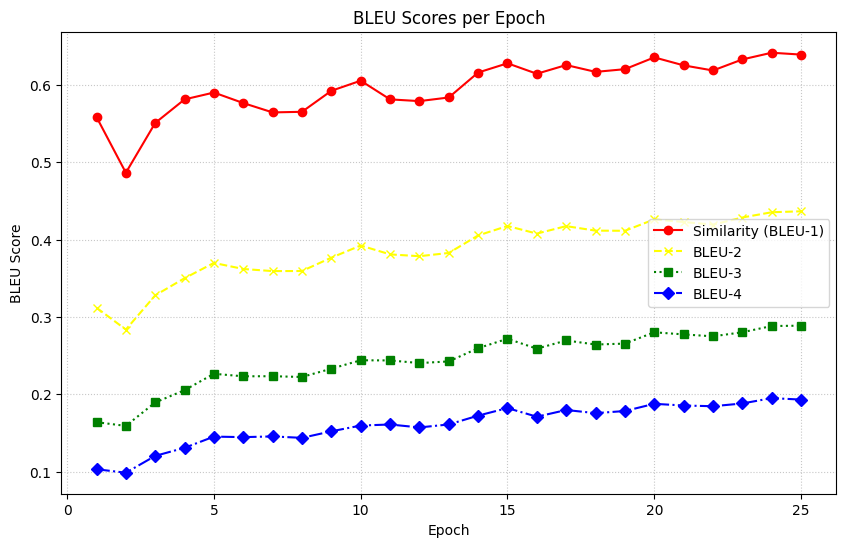

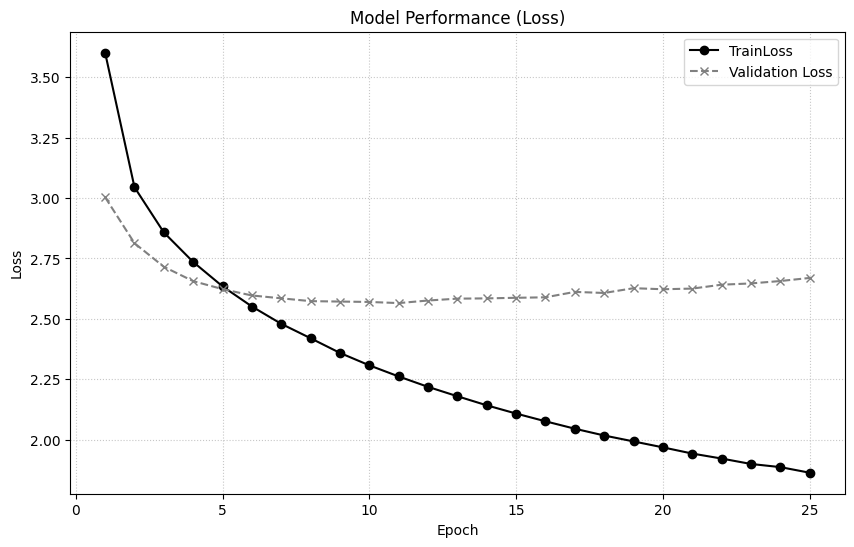

In [25]:

# --- Plotting Epoch-wise Metrics (Separate Figures) ---

# Figure 1: BLEU Scores per Epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs_list, bleu1_scores, marker='o', linestyle='-', color='red', label='Similarity (BLEU-1)')
plt.plot(epochs_list, bleu2_scores, marker='x', linestyle='--', color='yellow', label='BLEU-2')
plt.plot(epochs_list, bleu3_scores, marker='s', linestyle=':', color='green', label='BLEU-3')
plt.plot(epochs_list, bleu4_scores, marker='D', linestyle='-.', color='blue', label='BLEU-4')
plt.title('BLEU Scores per Epoch')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show() # Display this figure

# Figure 2: Loss over Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs_list, train_losses, marker='o', linestyle='-', color='black', label='TrainLoss')
plt.plot(epochs_list, val_losses, marker='x', linestyle='--', color='gray', label='Validation Loss')
plt.title('Model Performance (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show() # Display this figure



--- Starting Test Phase ---
Loaded models from epoch 25 for testing.

Starting Test Inference...
Processed 320 test samples...
Processed 640 test samples...
Processed 960 test samples...
Processed 1280 test samples...
Processed 1600 test samples...
Processed 1920 test samples...
Processed 2240 test samples...
Processed 2560 test samples...
Processed 2880 test samples...
Processed 3200 test samples...
Processed 3520 test samples...
Processed 3840 test samples...
Test inference complete.
Test predictions saved to /workspace/TestPredictions_CLIP_LSTM.csv
Calculating BLEU scores for 4046 predictions...
Individual BLEU scores saved to /workspace/TestScores_CLIP_LSTM.csv
Test phase complete!

--- Plotting Histograms of Test Prediction BLEU Scores ---
Loaded '/workspace/TestScores_CLIP_LSTM.csv' for histogram plotting. Shape: (4046, 6)


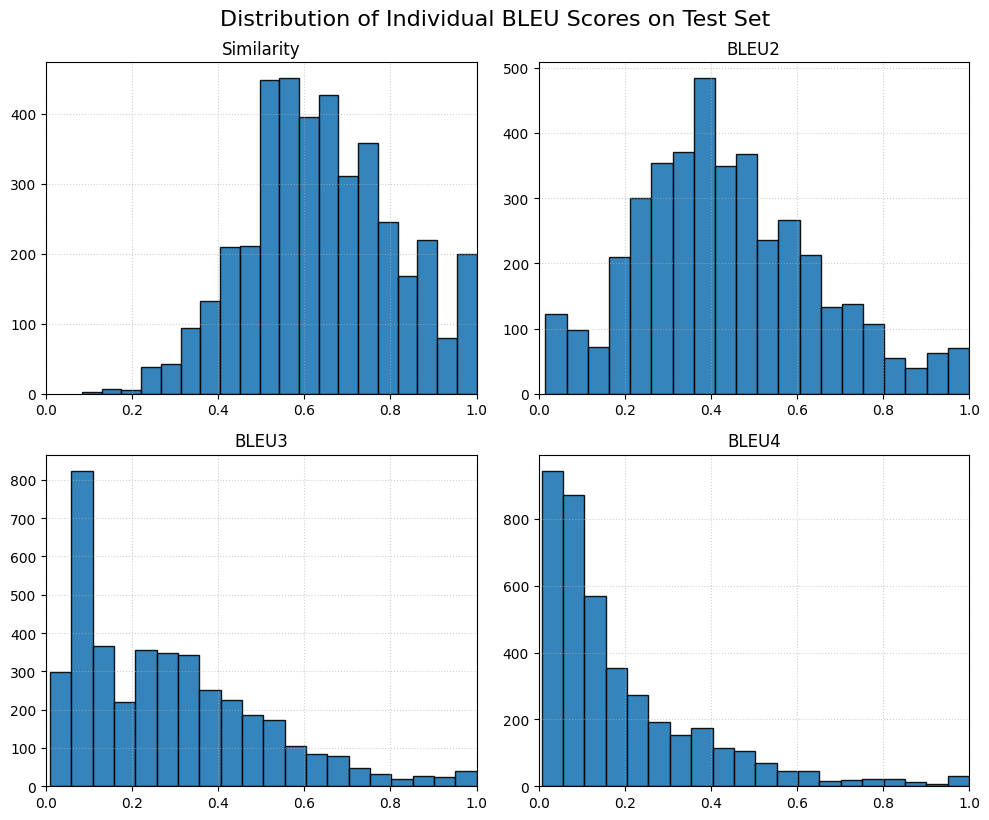


--- Evaluating Prediction Performance on Sample Images (Qualitative) ---

--- Sample 1 ---
Image File: 3396157719_6807d52a81.jpg


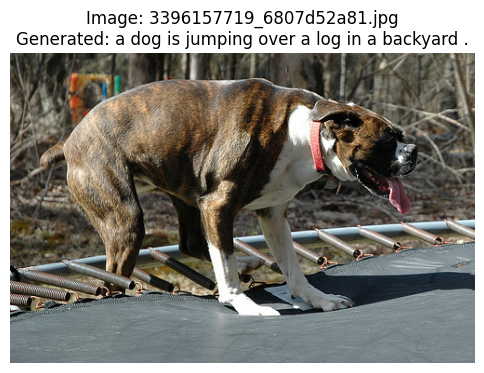

Ground Truth Captions:
  Ref 1: a brown and white dog on a trampoline with a forest in the background .
  Ref 2: a brown and white dog with a red collar getting on a trampoline
  Ref 3: a dog gets on a trampoline .
  Ref 4: dog with a red collar on a trampoline
  Ref 5: the brown and white dog is standing on a trampoline with its tongue hanging out .
Generated Caption: a dog is jumping over a log in a backyard .
  BLEU-1 (Similarity) for sample: 0.5306
  BLEU-2 for sample: 0.2974
  BLEU-3 for sample: 0.0936
  BLEU-4 for sample: 0.0541

--- Sample 2 ---
Image File: 2915538325_59e11276dd.jpg


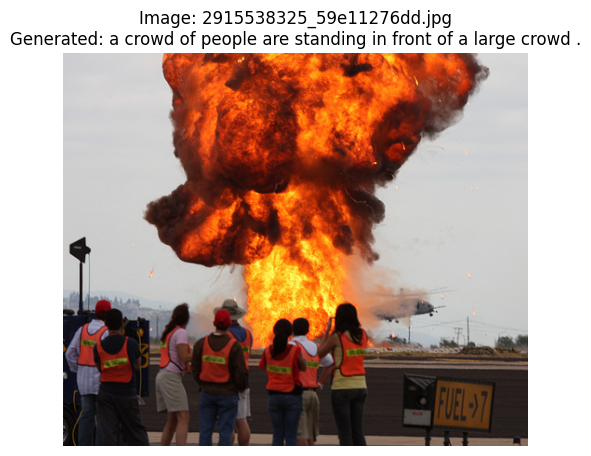

Ground Truth Captions:
  Ref 1: a crowd of people in orange vests looks on as a fireball rises into the sky at an airport .
  Ref 2: a group of people watching a large explosion .
  Ref 3: a group of people wearing orange vests watch a large fire near a helicopter .
  Ref 4: people dressed in hi viz jackets are watching a helicopter fly past an explosion .
  Ref 5: the crowd is watching the fiery explosion .
Generated Caption: a crowd of people are standing in front of a large crowd .
  BLEU-1 (Similarity) for sample: 0.5936
  BLEU-2 for sample: 0.4119
  BLEU-3 for sample: 0.2979
  BLEU-4 for sample: 0.2182

--- Sample 3 ---
Image File: 1456630952_dd4778a48f.jpg


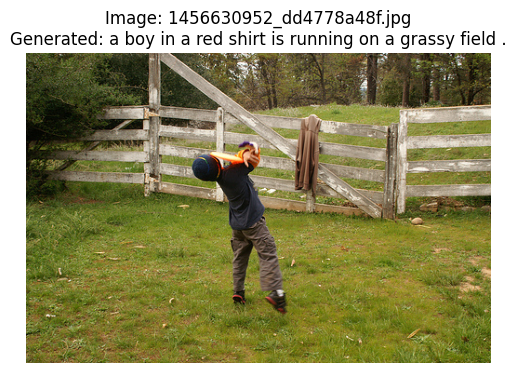

Ground Truth Captions:
  Ref 1: a boy is catching an orange frisbee in front of a wooden gate .
  Ref 2: a boy is trying to catch a frisbee in a field .
  Ref 3: a boy plays outside near a wooden fence .
  Ref 4: a child in a blue cap is near an unpainted wooden fence .
  Ref 5: a little boy stops a frisbee with his face outside .
Generated Caption: a boy in a red shirt is running on a grassy field .
  BLEU-1 (Similarity) for sample: 0.6154
  BLEU-2 for sample: 0.3922
  BLEU-3 for sample: 0.1118
  BLEU-4 for sample: 0.0612

End-to-End Execution Complete!


In [26]:

    # --- Test Phase: Generate Predictions and Calculate Individual Metrics ---
    print("\n--- Starting Test Phase ---")

    # Load the trained models for testing
    # For simplicity, we load the models from the last epoch.
    # In a real scenario, you might want to load the "best" model based on validation metrics.
    loaded_encoder_path = os.path.join(CONFIG["model_path"], f"encoder-{CONFIG['num_epochs']}.pth")
    loaded_decoder_path = os.path.join(CONFIG["model_path"], f"decoder-{CONFIG['num_epochs']}.pth")

    if os.path.exists(loaded_encoder_path) and os.path.exists(loaded_decoder_path):
        encoder.load_state_dict(torch.load(loaded_encoder_path, map_location=device))
        decoder.load_state_dict(torch.load(loaded_decoder_path, map_location=device))
        print(f"Loaded models from epoch {CONFIG['num_epochs']} for testing.")
    else:
        print("Warning: Saved models not found. Using the last state of trained models.")

    # 1. Generate predictions on the test set
    img_names_test, predicted_captions_test = test_inference(encoder, decoder, test_loader, vocab, device)

    # 2. Save predictions to a CSV
    test_predictions_df = pd.DataFrame({'ImageName': img_names_test, 'Predicted': predicted_captions_test})
    predicted_captions_output_path = os.path.join(CONFIG["model_path"], CONFIG["test_predictions_file"])
    test_predictions_df.to_csv(predicted_captions_output_path, index=False)
    print(f"Test predictions saved to {predicted_captions_output_path}")

    # 3. Calculate individual BLEU scores and save them to a CSV
    test_scores_output_path = os.path.join(CONFIG["model_path"], CONFIG["test_scores_file"])
    metrics_calculator = MetricsCalculator(all_image_to_captions_map, # Pass the map with ALL ground truths
                                           predicted_captions_output_path,
                                           test_scores_output_path)
    metrics_calculator.calculate_and_save()
    print("Test phase complete!")

    # --- Plotting Histograms of Individual BLEU Scores ---
    print("\n--- Plotting Histograms of Test Prediction BLEU Scores ---")
    try:
        test_scores_df = pd.read_csv(test_scores_output_path)
        print(f"Loaded '{CONFIG['test_scores_file']}' for histogram plotting. Shape: {test_scores_df.shape}")
    except FileNotFoundError:
        print(f"Error: '{CONFIG['test_scores_file']}' not found at '{test_scores_output_path}'. Cannot plot histograms.")
        exit()

    # Columns to plot histograms for
    histogram_cols = {
        'BLEU-1': 'Similarity',
        'BLEU-2': 'BLEU2',
        'BLEU-3': 'BLEU3',
        'BLEU-4': 'BLEU4'
    }

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()

    for i, (col_name_csv, col_name_plot) in enumerate(histogram_cols.items()):
        if col_name_csv in test_scores_df.columns:
            axes[i].hist(test_scores_df[col_name_csv], bins=20, edgecolor='black', alpha=0.9)
            axes[i].set_title(col_name_plot)
            axes[i].grid(True, linestyle=':', alpha=0.6)
            axes[i].set_xlim(0, 1) # BLEU scores are between 0 and 1
        else:
            print(f"Warning: Column '{col_name_csv}' not found in '{CONFIG['test_scores_file']}'. Skipping its histogram.")

    plt.tight_layout()
    plt.suptitle('Distribution of Individual BLEU Scores on Test Set', y=1.02, fontsize=16) # Overall title
    plt.show()

 
    # --- Individual Prediction Samples (Text Output and Image Display) ---
    print("\n--- Evaluating Prediction Performance on Sample Images (Qualitative) ---")

    num_samples_to_show = 3
    # Get random indices from the test dataset for qualitative analysis
    random_indices_test_dataset = random.sample(range(len(test_dataset)), min(num_samples_to_show, len(test_dataset)))

    for i, idx in enumerate(random_indices_test_dataset):
        # We need the original image path to display it
        # The test_dataset[idx] gives (image_tensor, caption_tensor, image_filename, original_caption_text)
        sample_image_tensor, _, sample_image_name, _ = test_dataset[idx]

        # Construct the full path to the original image file
        # Make sure CONFIG["image_dir"] is correctly set to your images directory (e.g., '/workspace/flickr8k/Images')
        original_image_path = os.path.join(CONFIG["image_dir"], sample_image_name)

        input_image = sample_image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            features = encoder(input_image)
            sampled_ids = decoder.sample(features)

        generated_caption_tokens = []
        for word_id in sampled_ids[0].cpu().numpy():
            word = vocab.idx2word[word_id]
            if word == '<EOS>':
                break
            if word == '<SOS>' or word == '<PAD>':
                continue
            generated_caption_tokens.append(word)

        generated_caption_str = ' '.join(generated_caption_tokens)

        ground_truth_references = all_image_to_captions_map.get(sample_image_name, [])

        print(f"\n--- Sample {i+1} ---")
        print(f"Image File: {sample_image_name}")

        # --- Display the image ---
        try:
            img_to_display = Image.open(original_image_path).convert("RGB")
            plt.figure(figsize=(6, 6))
            plt.imshow(img_to_display)
            plt.title(f"Image: {sample_image_name}\nGenerated: {generated_caption_str}")
            plt.axis('off') # Hide axes
            plt.show() # Display the image plot
        except FileNotFoundError:
            print(f"Warning: Image file not found at {original_image_path}. Cannot display.")
        except Exception as e:
            print(f"Error displaying image {original_image_path}: {e}")
        # --- End of Image Display ---


        print(f"Ground Truth Captions:")
        for ref_idx, ref_tokens in enumerate(ground_truth_references):
            print(f"  Ref {ref_idx+1}: {' '.join(ref_tokens)}")
        print(f"Generated Caption: {generated_caption_str}")

        if ground_truth_references:
            bleu1_sample = sentence_bleu(ground_truth_references, generated_caption_tokens, weights=(1.0,), smoothing_function=smooth_fn)
            bleu2_sample = sentence_bleu(ground_truth_references, generated_caption_tokens, weights=(0.5, 0.5), smoothing_function=smooth_fn)
            bleu3_sample = sentence_bleu(ground_truth_references, generated_caption_tokens, weights=(1./3., 1./3., 1./3.), smoothing_function=smooth_fn)
            bleu4_sample = sentence_bleu(ground_truth_references, generated_caption_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn)

            print(f"  BLEU-1 (Similarity) for sample: {bleu1_sample:.4f}")
            print(f"  BLEU-2 for sample: {bleu2_sample:.4f}")
            print(f"  BLEU-3 for sample: {bleu3_sample:.4f}")
            print(f"  BLEU-4 for sample: {bleu4_sample:.4f}")
        else:
            print("  No ground truth captions available for BLEU calculation.")

    print("\nEnd-to-End Execution Complete!")

In [37]:
import matplotlib.pyplot as plt # Ensure matplotlib.pyplot is imported
from PIL import Image           # Ensure PIL.Image is imported (should be already)
import random                   # Ensure random is imported (should be already)

In [36]:


# ... (rest of your code) ...


IndentationError: unexpected indent (1323221116.py, line 8)